In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(suppress=True)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

NUM_BITS = 10600
AVG_EMD_BASELINE_EoL = 1.346362954366226

In [2]:
def get_wi(i_bi, i_bw):
    return int(i_bi/i_bw)

def get_wbi(i_bi, i_bw):
    return int(i_bi%i_bw)

def get_wi_wbi(i_bi, i_bw):
    return get_wi(i_bi, i_bw), get_wbi(i_bi, i_bw)

def parse_ranking_file(file):
    """
    Parse the ranking file which contains a list of (bit index, ranking val) 
    into a list of bit indices and a list of ranking values
    """
    bit_indices = []
    vals = []
    with open(file, 'r') as f:
        for i, line in enumerate(f):
            if i == 0:
                # Skip the header
                continue
            line = line.strip()
            if line:
                bit_idx, val = line.split(',')
                bit_indices.append(int(bit_idx))
                vals.append(float(val))
    return bit_indices, vals

In [3]:
ground_truth_rank, ground_truth_emd = parse_ranking_file('encoder_param_ranking_ground_truth.txt')

In [4]:
len(ground_truth_emd)

10600

In [94]:
# Get top 1% highest ranking bits
top_1pct = int(len(ground_truth_rank) * 0.01)
top_1pct_bit_indices = ground_truth_rank[:top_1pct]
top_1pct_emd = ground_truth_emd[:top_1pct]
# Get top 3% highest ranking bits
top_3pct = int(len(ground_truth_rank) * 0.03)
top_3pct_bit_indices = ground_truth_rank[:top_3pct]
top_3pct_emd = ground_truth_emd[:top_3pct]
# Get top 10% highest ranking bits
top_10pct = int(len(ground_truth_rank) * 0.1)
top_10pct_bit_indices = ground_truth_rank[:top_10pct]
top_10pct_emd = ground_truth_emd[:top_10pct]
# Get top 30% highest ranking bits
top_30pct = int(len(ground_truth_rank) * 0.3)
top_30pct_bit_indices = ground_truth_rank[:top_30pct]
top_30pct_emd = ground_truth_emd[:top_30pct]

In [6]:
top_10pct_bit_indices[:15]

[5, 240, 5825, 165, 45, 250, 6, 8145, 2370, 80, 166, 35, 8160, 4325, 125]

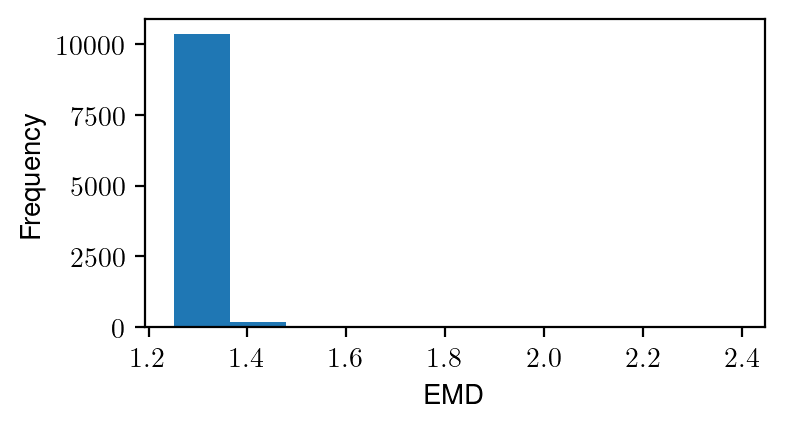

In [7]:
# Plot histogram of the EMD values
fig, ax = plt.subplots(figsize=(4,2)) # Sample figsize in inches
ax.hist(ground_truth_emd)
ax.set_xlabel('EMD')
ax.set_ylabel('Frequency')
plt.savefig('plots/histogram_faulty_emd.pdf', dpi=300, bbox_inches='tight')

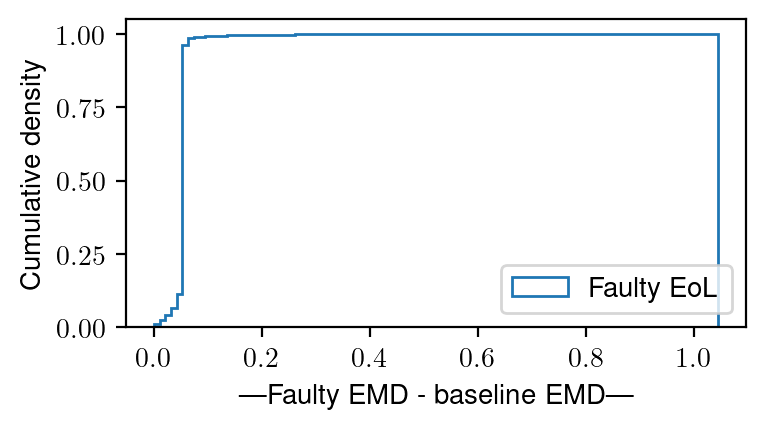

In [8]:
# Plot histogram of the delta EMD values from the baseline
fig, ax = plt.subplots(figsize=(4,2)) # Sample figsize in inches
ax.hist(np.absolute(np.array(ground_truth_emd) - AVG_EMD_BASELINE_EoL), cumulative=True, density=True, bins=100, histtype='step', label='Faulty EoL')
ax.set_xlabel('|Faulty EMD - baseline EMD|')
ax.set_ylabel('Cumulative density')
ax.legend(loc='lower right')
plt.savefig('plots/histogram_faulty_delta_emd.pdf', dpi=300, bbox_inches='tight')

In [184]:
# Convert encoder Hessian parameter ranking to bit indices 
BITWIDTH = 5
CUTOFF = 0.15
def sort_bits_MSB_to_LSB(param_bit_order_ranking):
    """
    Given a bit ranking in which the bits are ordered from MSB to LSB in
    parameter order, return a list of bit indices where all the MSBs are first,
    followed by all the MSBs - 1, etc.
    """
    # Sort from MSB to LSB
    sign_bits = param_bit_order_ranking[0::BITWIDTH]
    int_bits = param_bit_order_ranking[1::BITWIDTH]
    frac_bits = np.concatenate((
        param_bit_order_ranking[2::BITWIDTH], 
        param_bit_order_ranking[3::BITWIDTH], 
        param_bit_order_ranking[4::BITWIDTH]
    ))
    bit_rank = np.concatenate((sign_bits, int_bits, frac_bits))
    return bit_rank

def convert_param_ranking_to_bit_ranking(conv_param_ranking, conv_param_score,dense_param_ranking, dense_param_score):
    # Conv param ranking
    num_conv_bits = len(conv_param_ranking) * BITWIDTH
    bit_level_rank_conv = []
    remaining_conv_bits = []
    for i, param in enumerate(conv_param_ranking):
        bit_idx = param * BITWIDTH
        if conv_param_score[i] > CUTOFF:
            bit_level_rank_conv.append(bit_idx)
            for j in range(1, BITWIDTH):
                bit_level_rank_conv.append(bit_idx + j)
        else:
            remaining_conv_bits.append(bit_idx)
            for j in range(1, BITWIDTH):
                remaining_conv_bits.append(bit_idx + j)
    print(len(bit_level_rank_conv))
    # Sort from MSB to LSB
    conv_bit_rank = sort_bits_MSB_to_LSB(bit_level_rank_conv)
    remaining_conv_bits = sort_bits_MSB_to_LSB(remaining_conv_bits)
    # Dense param ranking
    bit_level_rank_dense = []
    remaining_dense_bits = []
    for i, param in enumerate(dense_param_ranking):
        bit_idx = param * BITWIDTH + num_conv_bits
        if dense_param_score[i] > CUTOFF:
            bit_level_rank_dense.append(bit_idx)
            for j in range(1, BITWIDTH):
                bit_level_rank_dense.append(bit_idx + j)
        else:
            remaining_dense_bits.append(bit_idx)
            for j in range(1, BITWIDTH):
                remaining_dense_bits.append(bit_idx + j)
    # Sort from MSB to LSB
    dense_bit_rank = sort_bits_MSB_to_LSB(bit_level_rank_dense)
    remaining_dense_bits = sort_bits_MSB_to_LSB(remaining_dense_bits)
    # Concatenate conv and dense bit ranking
    bit_ranking = np.concatenate((conv_bit_rank, dense_bit_rank, remaining_conv_bits, remaining_dense_bits))
    return bit_ranking

In [185]:
# Parse hessian ranking file
conv_hess_rank, conv_hess_score = parse_ranking_file('sensitivity_ranking_layer_conv2d_0_m.txt')
dense_hess_rank, dense_hess_score = parse_ranking_file('sensitivity_ranking_layer_encoded_vector.txt')
hessian_rank = convert_param_ranking_to_bit_ranking(conv_hess_rank, conv_hess_score,dense_hess_rank, dense_hess_score)
# Parse (top 3) hessian ranking file
conv_hess_rank_top3, conv_hess_score_top3 = parse_ranking_file('top3_hess_ranking_layer_conv2d_0_m.txt')
dense_hess_rank_top3, dense_hess_score_top3 = parse_ranking_file('top3_hess_ranking_layer_encoded_vector.txt')
hessian_rank_top3 = convert_param_ranking_to_bit_ranking(
    conv_hess_rank_top3, 
    conv_hess_score_top3, 
    dense_hess_rank_top3, 
    dense_hess_score_top3
)
# Parse (top 5) hessian ranking file
conv_hess_rank_top5, conv_hess_score_top5 = parse_ranking_file('top5_hess_ranking_layer_conv2d_0_m.txt')
dense_hess_rank_top5, dense_hess_score_top5 = parse_ranking_file('top5_hess_ranking_layer_encoded_vector.txt')
hessian_rank_top5 = convert_param_ranking_to_bit_ranking(
    conv_hess_rank_top5, 
    conv_hess_score_top5, 
    dense_hess_rank_top5, 
    dense_hess_score_top5
)
# Parse (top 8) hessian ranking file
conv_hess_rank_top8, conv_hess_score_top8 = parse_ranking_file('top8_hess_ranking_layer_conv2d_0_m.txt')
dense_hess_rank_top8, dense_hess_score_top8 = parse_ranking_file('top8_hess_ranking_layer_encoded_vector.txt')
hessian_rank_top8 = convert_param_ranking_to_bit_ranking(
    conv_hess_rank_top8, 
    conv_hess_score_top8, 
    dense_hess_rank_top8, 
    dense_hess_score_top8
)
# Parse gradient ranking file
conv_grad_rank, conv_grad_score = parse_ranking_file('gradient_ranking_layer_conv2d_0_m.txt')
dense_grad_rank, dense_grad_score = parse_ranking_file('gradient_ranking_layer_encoded_vector.txt')
gradient_rank = convert_param_ranking_to_bit_ranking(conv_grad_rank, conv_grad_score, dense_grad_rank, dense_grad_score)
print(f"Hessian rank: {hessian_rank[:15]}")
print(f"Hessian top 3 rank: {hessian_rank_top3[:15]}")
print(f"Hessian top 5 rank: {hessian_rank_top5[:15]}")
print(f"Hessian top 8 rank: {hessian_rank_top8[:15]}")
print(f"Gradient rank: {gradient_rank[:15]}")


50
135
145
190
10
Hessian rank: [ 20   5 100 260 340  60  55  15 140 300  21   6 101 261 341]
Hessian top 3 rank: [  5  20 100 260  45 340  60  55  10 325 170 125 110 165 300]
Hessian top 5 rank: [ 20   5 165 260 100 140 125 340  45  60 220  10  55 180 300]
Hessian top 8 rank: [  5  20 100 260 340  60 140 125 110 165  15 300 220 325  65]
Gradient rank: [  65   55   66   56   67   57   68   58   69   59 1790 1791 1792 1793
 1794]


Found all bits with random at 10519 bits flipped
Found all bits with deterministic at 8835 bits flipped
Found all bits with bit ordered at 6458 bits flipped
Found all bits with Hessian at 6899 bits flipped
Found all bits with gradient at 6536 bits flipped
Found all bits with Hessian top 3 at 6689 bits flipped
Found all bits with Hessian top 5 at 5031 bits flipped
Found all bits with Hessian top 8 at 5139 bits flipped


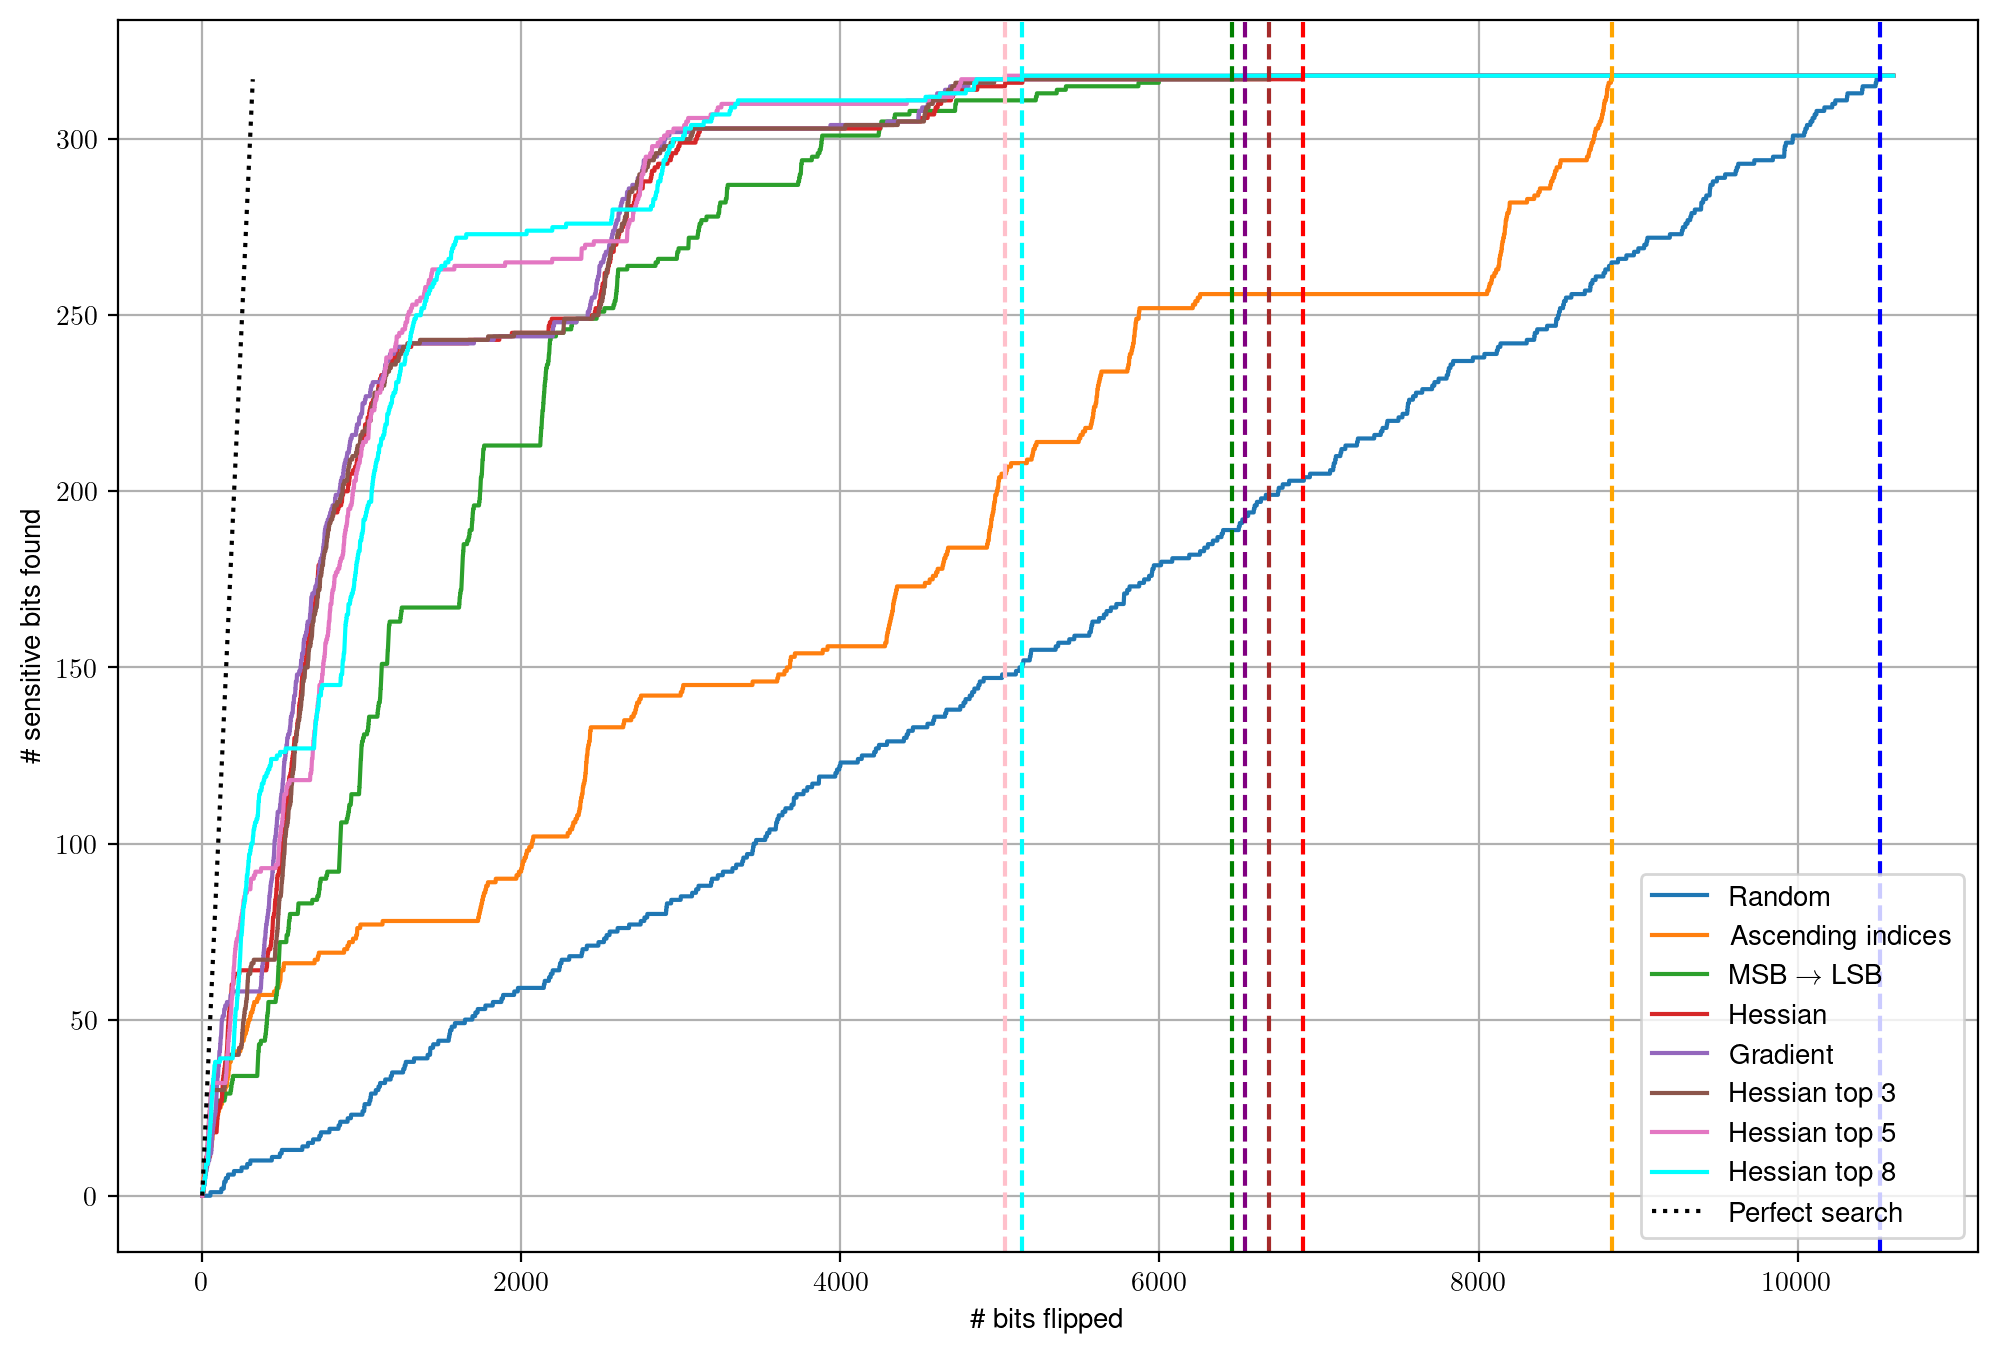

In [187]:
# Generate random list of bit indices to simulate random fault injection
random.seed(7654)
random_bit_indices = random.sample(range(NUM_BITS), NUM_BITS)
deterministic_bit_indices = np.arange(NUM_BITS)
# Search all sign bits first, then integer bits, then fractional bits
bit_ordered_indices = []
sign_bits = deterministic_bit_indices[0::5]
int_bits = deterministic_bit_indices[1::5]
frac_bits = np.concatenate((deterministic_bit_indices[2::5], deterministic_bit_indices[3::5], deterministic_bit_indices[4::5]))
bit_ordered_indices = np.concatenate((sign_bits, int_bits, frac_bits))

TOP_K_LABEL = 'top_3pct'
top_k_bit_indices = top_3pct_bit_indices
NUM_TOP_K_BIT_INDICES = len(top_k_bit_indices)

grad_found = []
random_found = []
hessian_found = []
hessian_top3_found = []
hessian_top5_found = []
hessian_top8_found = []
bit_ordered_found = []
deterministic_found = []
for i in range(NUM_BITS):
    if random_bit_indices[i] in top_k_bit_indices:
        random_found.append(1)
    if random_bit_indices[i] not in top_k_bit_indices:
        random_found.append(0)
    if deterministic_bit_indices[i] in top_k_bit_indices:
        deterministic_found.append(1)
    if deterministic_bit_indices[i] not in top_k_bit_indices:
        deterministic_found.append(0)
    if bit_ordered_indices[i] in top_k_bit_indices:
        bit_ordered_found.append(1)
    if bit_ordered_indices[i] not in top_k_bit_indices:
        bit_ordered_found.append(0)
    if hessian_rank[i] in top_k_bit_indices:
        hessian_found.append(1)
    if hessian_rank[i] not in top_k_bit_indices:
        hessian_found.append(0)
    if gradient_rank[i] in top_k_bit_indices:
        grad_found.append(1)
    if gradient_rank[i] not in top_k_bit_indices:
        grad_found.append(0)
    if hessian_rank_top3[i] in top_k_bit_indices:
        hessian_top3_found.append(1)
    if hessian_rank_top3[i] not in top_k_bit_indices:
        hessian_top3_found.append(0)
    if hessian_rank_top5[i] in top_k_bit_indices:
        hessian_top5_found.append(1)
    if hessian_rank_top5[i] not in top_k_bit_indices:
        hessian_top5_found.append(0)
    if hessian_rank_top8[i] in top_k_bit_indices:
        hessian_top8_found.append(1)
    if hessian_rank_top8[i] not in top_k_bit_indices:
        hessian_top8_found.append(0)
random_found = np.cumsum(np.array(random_found))
random_all_bits_found = np.argwhere(random_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with random at {random_all_bits_found} bits flipped")
deterministic_found = np.cumsum(np.array(deterministic_found))
deterministic_all_bits_found = np.argwhere(deterministic_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with deterministic at {deterministic_all_bits_found} bits flipped")
bit_ordered_found = np.cumsum(np.array(bit_ordered_found))
bit_ordered_all_bits_found = np.argwhere(bit_ordered_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with bit ordered at {bit_ordered_all_bits_found} bits flipped")
hessian_found = np.cumsum(np.array(hessian_found))
hess_all_bits_found = np.argwhere(hessian_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with Hessian at {hess_all_bits_found} bits flipped")
grad_found = np.cumsum(np.array(grad_found))
grad_all_bits_found = np.argwhere(grad_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with gradient at {grad_all_bits_found} bits flipped")
hessian_top3_found = np.cumsum(np.array(hessian_top3_found))
hess_top3_all_bits_found = np.argwhere(hessian_top3_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with Hessian top 3 at {hess_top3_all_bits_found} bits flipped")
hessian_top5_found = np.cumsum(np.array(hessian_top5_found))
hess_top5_all_bits_found = np.argwhere(hessian_top5_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with Hessian top 5 at {hess_top5_all_bits_found} bits flipped")
hessian_top8_found = np.cumsum(np.array(hessian_top8_found))
hess_top8_all_bits_found = np.argwhere(hessian_top8_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with Hessian top 8 at {hess_top8_all_bits_found} bits flipped")


# Plot
fig, ax = plt.subplots(figsize=(12,8)) # Sample figsize in inches
ax.plot(np.arange(NUM_BITS), random_found, label='Random')
ax.plot(np.arange(NUM_BITS), deterministic_found, label='Ascending indices')
ax.plot(np.arange(NUM_BITS), bit_ordered_found, label=r'MSB $\rightarrow$ LSB')
ax.plot(np.arange(NUM_BITS), hessian_found, label='Hessian')
ax.plot(np.arange(NUM_BITS), grad_found, label='Gradient')
ax.plot(np.arange(NUM_BITS), hessian_top3_found, label='Hessian top 3')
ax.plot(np.arange(NUM_BITS), hessian_top5_found, label='Hessian top 5')
ax.plot(np.arange(NUM_BITS), hessian_top8_found, color="cyan", label='Hessian top 8')
ax.plot(np.arange(NUM_TOP_K_BIT_INDICES), np.arange(NUM_TOP_K_BIT_INDICES), color='black', linestyle=':', label='Perfect search')
ax.set_xlabel('\# bits flipped')
ax.set_ylabel('\# sensitive bits found')
ax.legend()
ax.grid()
plt.axvline(x=random_all_bits_found, color='blue', linestyle='--')
plt.axvline(x=deterministic_all_bits_found, color='orange', linestyle='--')
plt.axvline(x=bit_ordered_all_bits_found, color='green', linestyle='--')
plt.axvline(x=hess_all_bits_found, color='red', linestyle='--')
plt.axvline(x=grad_all_bits_found, color='purple', linestyle='--')
plt.axvline(x=hess_top3_all_bits_found, color='brown', linestyle='--')
plt.axvline(x=hess_top5_all_bits_found, color='pink', linestyle='--')
plt.axvline(x=hess_top8_all_bits_found, color='cyan', linestyle='--')
plt.savefig(f'plots/fault_sensitivity_ranking_{TOP_K_LABEL}.pdf', dpi=300, bbox_inches='tight')

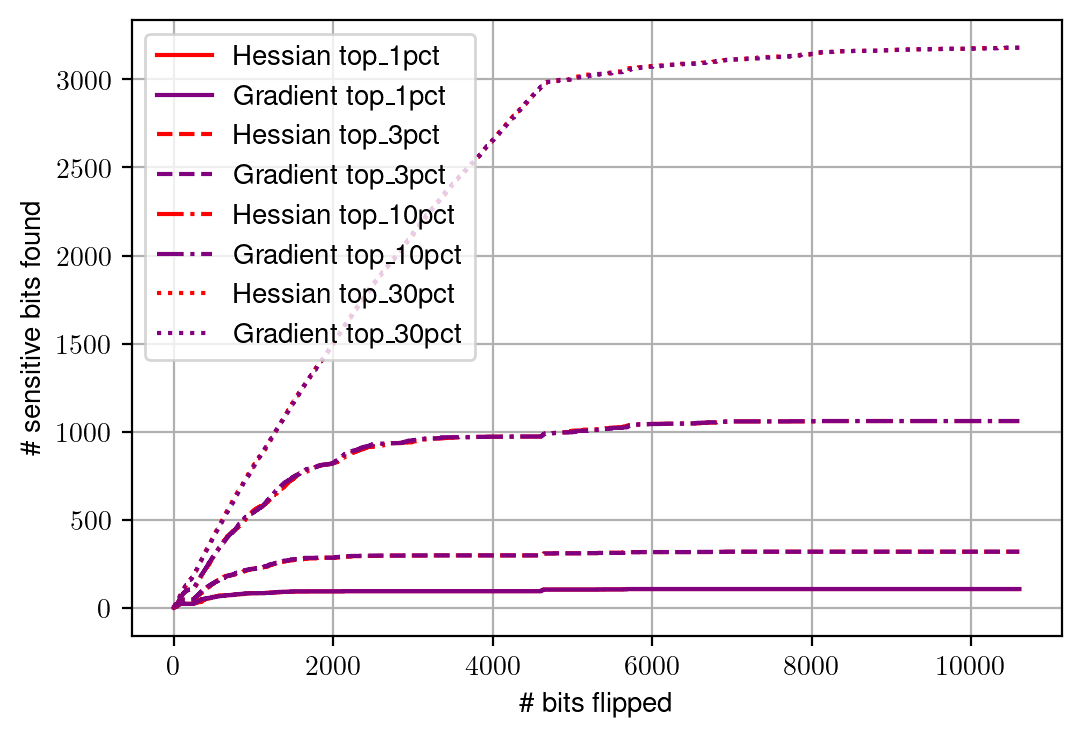

In [135]:
# Compare 1pct, 3pct, 10pct, and 30pct searches for Hessian and gradient
top_k_bit_indices = [top_1pct_bit_indices, top_3pct_bit_indices, top_10pct_bit_indices, top_30pct_bit_indices]
top_k_labels = ['top_1pct', 'top_3pct', 'top_10pct', 'top_30pct']
linestyles = ['-', '--', '-.', ':']

fig, ax = plt.subplots(figsize=(6,4)) # Sample figsize in inches
for i in range(len(top_k_bit_indices)):
    grad_found = []
    hessian_found = []
    for j in range(NUM_BITS):
        if hessian_rank[j] in top_k_bit_indices[i]:
            hessian_found.append(1)
        if hessian_rank[j] not in top_k_bit_indices[i]:
            hessian_found.append(0)
        if gradient_rank[j] in top_k_bit_indices[i]:
            grad_found.append(1)
        if gradient_rank[j] not in top_k_bit_indices[i]:
            grad_found.append(0)
    hessian_found = np.cumsum(np.array(hessian_found))
    grad_found = np.cumsum(np.array(grad_found))
    # Plot
    ax.plot(np.arange(NUM_BITS), hessian_found, label=f'Hessian {top_k_labels[i]}', linestyle=linestyles[i], color='red')
    ax.plot(np.arange(NUM_BITS), grad_found, label=f'Gradient {top_k_labels[i]}', linestyle=linestyles[i], color='purple')
ax.set_xlabel('\# bits flipped')
ax.set_ylabel('\# sensitive bits found')
ax.legend()
ax.grid()
plt.savefig(f'plots/fault_sensitivity_ranking_hess_grad_only.pdf', dpi=300, bbox_inches='tight')
